# Moving Box - Encoder Decoder Trainer

In [38]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *
from time import time

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect an ensemble of box data

In [39]:
train_collection = get_collection("../data/data/walking/32x32/train")
#train_collection = augment_reverse_color(train_collection)
#train_collection = augment_reverse_sequence(train_collection)
#train_collection = center_collections(train_collection)

total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

person01_walking_d1_uncomp
person01_walking_d2_uncomp
person01_walking_d3_uncomp
person01_walking_d4_uncomp
person02_walking_d1_uncomp
person02_walking_d2_uncomp
person02_walking_d3_uncomp
person02_walking_d4_uncomp
person03_walking_d1_uncomp
person03_walking_d2_uncomp
person03_walking_d3_uncomp
person03_walking_d4_uncomp
person04_walking_d1_uncomp
person04_walking_d2_uncomp
person04_walking_d3_uncomp
person04_walking_d4_uncomp
person05_walking_d1_uncomp
person05_walking_d2_uncomp
person05_walking_d3_uncomp
person05_walking_d4_uncomp
person06_walking_d1_uncomp
person06_walking_d2_uncomp
person06_walking_d3_uncomp
person06_walking_d4_uncomp
person07_walking_d1_uncomp
person07_walking_d2_uncomp
person07_walking_d3_uncomp
person07_walking_d4_uncomp
person08_walking_d1_uncomp
person08_walking_d2_uncomp
person08_walking_d3_uncomp
person08_walking_d4_uncomp
person09_walking_d1_uncomp
person09_walking_d2_uncomp
person09_walking_d3_uncomp
person09_walking_d4_uncomp
person10_walking_d1_uncomp
p

In [40]:
test_collection = get_collection("../data/data/walking/32x32/test")
#test_collection = augment_reverse_color(test_collection)
#test_collection = center_collections(test_collection)
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

person21_walking_d1_uncomp
person21_walking_d2_uncomp
person21_walking_d3_uncomp
person21_walking_d4_uncomp
person22_walking_d1_uncomp
person22_walking_d2_uncomp
person22_walking_d3_uncomp
person22_walking_d4_uncomp
person23_walking_d1_uncomp
person23_walking_d2_uncomp
person23_walking_d3_uncomp
person23_walking_d4_uncomp
person24_walking_d1_uncomp
person24_walking_d2_uncomp
person24_walking_d3_uncomp
person24_walking_d4_uncomp
person25_walking_d1_uncomp
person25_walking_d2_uncomp
person25_walking_d3_uncomp
person25_walking_d4_uncomp

After Augmentation: Test set has 20 collections, 13588 images in total


## Sample from Collection

In [41]:
def sample(collection, batch_size = 8, gap = 1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - 1), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(train_collection, batch_size, gap = gap)

def sample_test(batch_size = 8, gap = 1):  return sample(test_collection, batch_size, gap)

## Take a look at Training data

Range of Image Piece Value: [13, 246]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


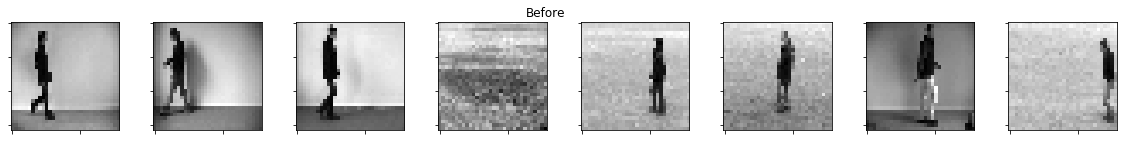

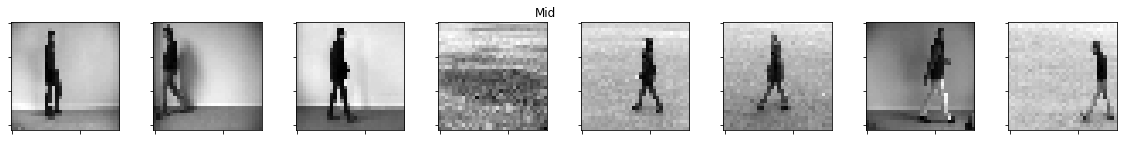

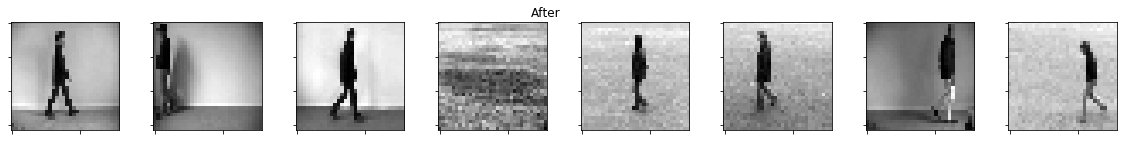

In [42]:
def show_sample_train(batch_size, gap):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 8, gap = 9)

## Sample of Test Data

Range of Image Piece Value: [16, 254]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


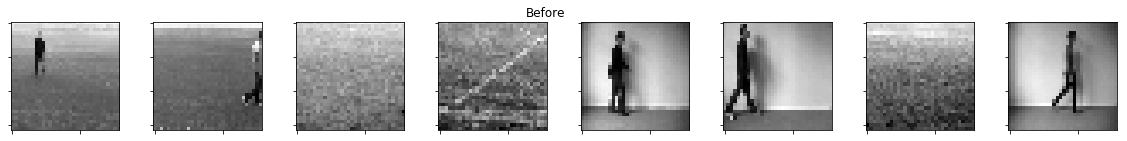

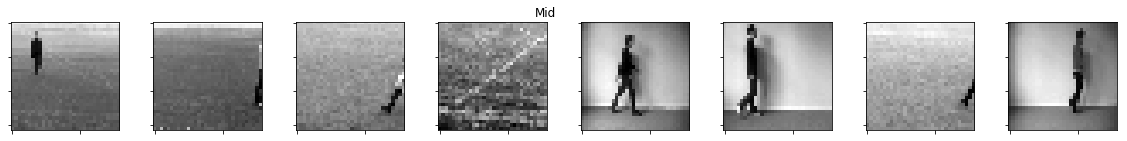

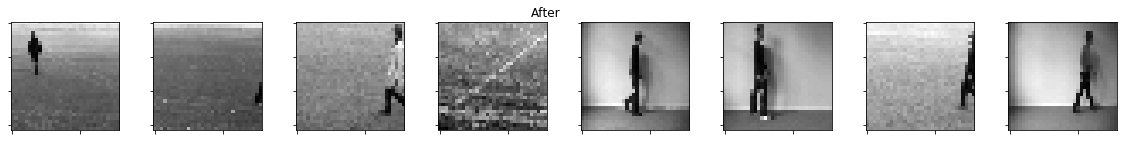

In [49]:
def show_sample_test(batch_size, gap):
    before, after, mid = sample_test(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")

show_sample_test(batch_size=8, gap = 9)

## Target

### Gap: How harsh do you want to train the model?

In [50]:
gap = 1

### Model Capacity

In [51]:
feature_channel = 256

## Param

In [77]:
batch_size = 32

learning_rate = 5e-4

beta = 0.7 # defalut 0.9 for adam
num_iteration = 10000

model_save_path = "../trained_model/box-32x32-encoder-decorder/{}/".format(time())

## Create Directory for Model to be saved

In [78]:
try:
    os.makedirs(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

Model to be saved at ../trained_model/box-32x32-encoder-decorder/1526402256.7386475/


# Encoder

In [79]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 8, 8, feature_channel]
    """
    x = tf.reshape(img, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 64, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 128, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    return x

# Decoder

In [80]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = feature
    x = tf.layers.conv2d(x, filters = 128, kernel_size=5, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Generator

### Loss

In [81]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

### Get a Batch Generation

In [82]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [83]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [84]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        loss = sess.run(G_loss, \
                        feed_dict = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False})
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [85]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32], "batch_mid")
batch_before     = tf.placeholder(tf.float32, [None, 32, 32], "batch_before")
batch_after      = tf.placeholder(tf.float32, [None, 32, 32], "batch_after")

decoder_input   = tf.placeholder(tf.float32, [None, 8, 8, feature_channel], "decoder_input")
is_training      = tf.placeholder(tf.bool, (), name = "is_training")

with tf.variable_scope("generator") as scope:
    encoder_output_before = encode(batch_before)
    encoder_output_after = encode(batch_after)
    G_batch = decode(decoder_input)
    
G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
# add to saver
tf.add_to_collection('decoder', G_batch)
tf.add_to_collection('encoder', encoder_output_before)

In [86]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6, num_plot = 6):
    g_losses = []
    saver = tf.train.Saver()
    for i in range(num_iteration):
        # get a sample
        gap = np.random.choice([1,3,5])
        real_before, real_after, real_mid = sample_train(batch_size, gap)
#         dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        feature_before, feature_after = sess.run([encoder_output_before, \
                                                  encoder_output_after], {batch_before: real_before, batch_after: real_after})
        ave_feature = (feature_before + feature_after)/2
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], {decoder_input: ave_feature, batch_mid: real_mid})
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | Gap = {}".format(i, G_loss_curr, gap))
            
        if i%plot_every == 0:
            real_before, real_after, real_mid = sample_train(num_plot, gap)
            feature_before, feature_after = sess.run([encoder_output_before, \
                                                  encoder_output_after], {batch_before: real_before, batch_after: real_after})
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {decoder_input: ave_feature, batch_mid: real_mid, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
    saver.save(sess, model_save_path, global_step = i)       
    return g_losses

# Train !

Iteration 0:  G_loss = 115660.47637939453 | Gap = 5


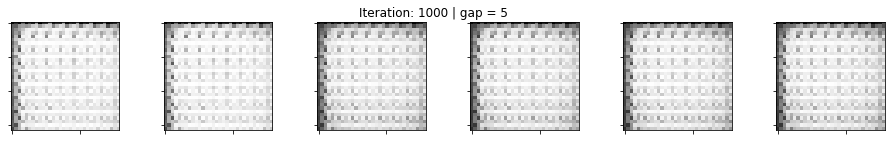

Iteration 80:  G_loss = 116195.88455200195 | Gap = 3
Iteration 160:  G_loss = 113879.28955078125 | Gap = 3
Iteration 240:  G_loss = 113979.42810058594 | Gap = 1
Iteration 320:  G_loss = 111160.51391601562 | Gap = 3
Iteration 400:  G_loss = 112475.64559936523 | Gap = 5
Iteration 480:  G_loss = 118977.04055786133 | Gap = 5
Iteration 560:  G_loss = 117799.69665527344 | Gap = 1
Iteration 640:  G_loss = 115016.68853759766 | Gap = 3
Iteration 720:  G_loss = 118245.86883544922 | Gap = 3
Iteration 800:  G_loss = 110489.3179321289 | Gap = 3
Iteration 880:  G_loss = 119853.50189208984 | Gap = 5
Iteration 960:  G_loss = 109278.41033935547 | Gap = 1


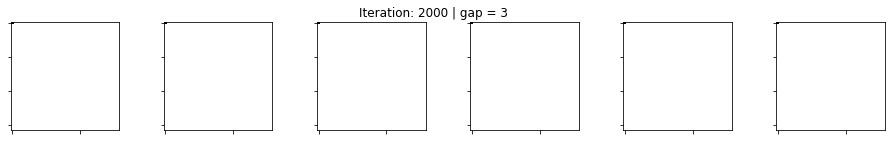

Iteration 1040:  G_loss = 121560.16067504883 | Gap = 5
Iteration 1120:  G_loss = 115005.72372436523 | Gap = 3
Iteration 1200:  G_loss = 113074.10339355469 | Gap = 1
Iteration 1280:  G_loss = 110401.07803344727 | Gap = 1
Iteration 1360:  G_loss = 118301.51000976562 | Gap = 5
Iteration 1440:  G_loss = 111948.78982543945 | Gap = 1
Iteration 1520:  G_loss = 117135.72235107422 | Gap = 3
Iteration 1600:  G_loss = 113381.52282714844 | Gap = 3
Iteration 1680:  G_loss = 113116.24282836914 | Gap = 1
Iteration 1760:  G_loss = 108398.70391845703 | Gap = 3
Iteration 1840:  G_loss = 116041.42776489258 | Gap = 5
Iteration 1920:  G_loss = 120276.17248535156 | Gap = 5
Iteration 2000:  G_loss = 120836.28845214844 | Gap = 3


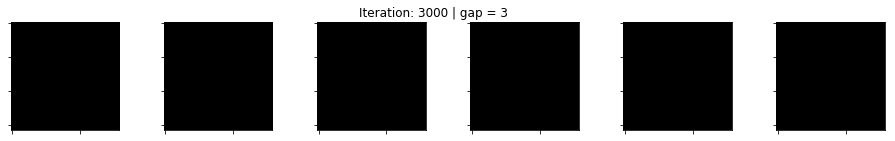

Iteration 2080:  G_loss = 109435.6608581543 | Gap = 1
Iteration 2160:  G_loss = 111007.87811279297 | Gap = 5
Iteration 2240:  G_loss = 102284.15908813477 | Gap = 3
Iteration 2320:  G_loss = 111230.33386230469 | Gap = 5
Iteration 2400:  G_loss = 110919.1635131836 | Gap = 3
Iteration 2480:  G_loss = 111144.93438720703 | Gap = 1
Iteration 2560:  G_loss = 117225.49530029297 | Gap = 3
Iteration 2640:  G_loss = 103581.2287902832 | Gap = 3
Iteration 2720:  G_loss = 117935.42999267578 | Gap = 5
Iteration 2800:  G_loss = 117557.40463256836 | Gap = 3
Iteration 2880:  G_loss = 105579.19052124023 | Gap = 3
Iteration 2960:  G_loss = 111528.48495483398 | Gap = 1


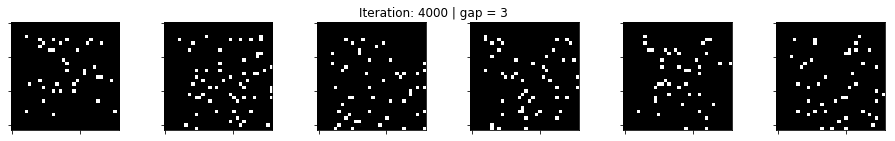

Iteration 3040:  G_loss = 111411.6618347168 | Gap = 5
Iteration 3120:  G_loss = 115059.11590576172 | Gap = 5
Iteration 3200:  G_loss = 120691.16226196289 | Gap = 1
Iteration 3280:  G_loss = 115529.45114135742 | Gap = 5
Iteration 3360:  G_loss = 115184.35134887695 | Gap = 5
Iteration 3440:  G_loss = 99989.12796020508 | Gap = 5
Iteration 3520:  G_loss = 118101.85546875 | Gap = 1
Iteration 3600:  G_loss = 112296.92459106445 | Gap = 1
Iteration 3680:  G_loss = 114923.48373413086 | Gap = 3
Iteration 3760:  G_loss = 116109.5979309082 | Gap = 3
Iteration 3840:  G_loss = 116047.71560668945 | Gap = 1
Iteration 3920:  G_loss = 122509.81155395508 | Gap = 5
Iteration 4000:  G_loss = 110461.89422607422 | Gap = 1


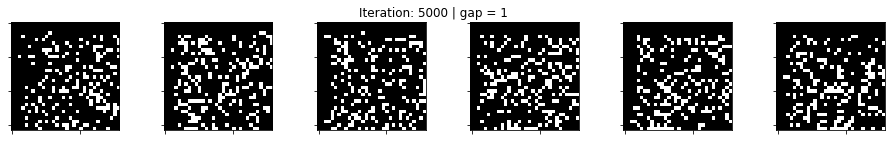

Iteration 4080:  G_loss = 108006.04064941406 | Gap = 1
Iteration 4160:  G_loss = 119823.19885253906 | Gap = 3
Iteration 4240:  G_loss = 112572.041015625 | Gap = 5
Iteration 4320:  G_loss = 124139.43649291992 | Gap = 1


KeyboardInterrupt: 

In [88]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every = 400, num_plot=6)

## Plot Learning Curve

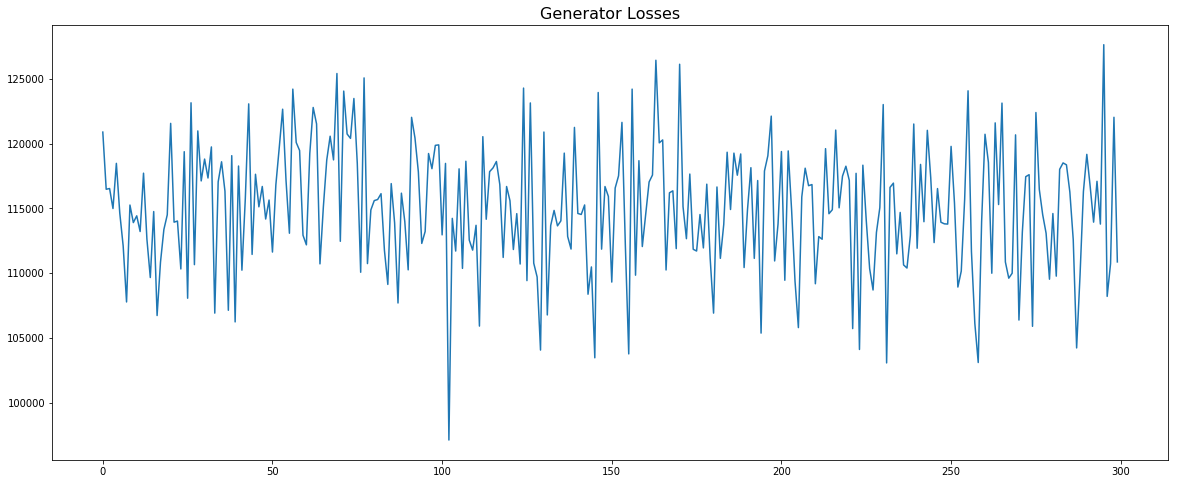

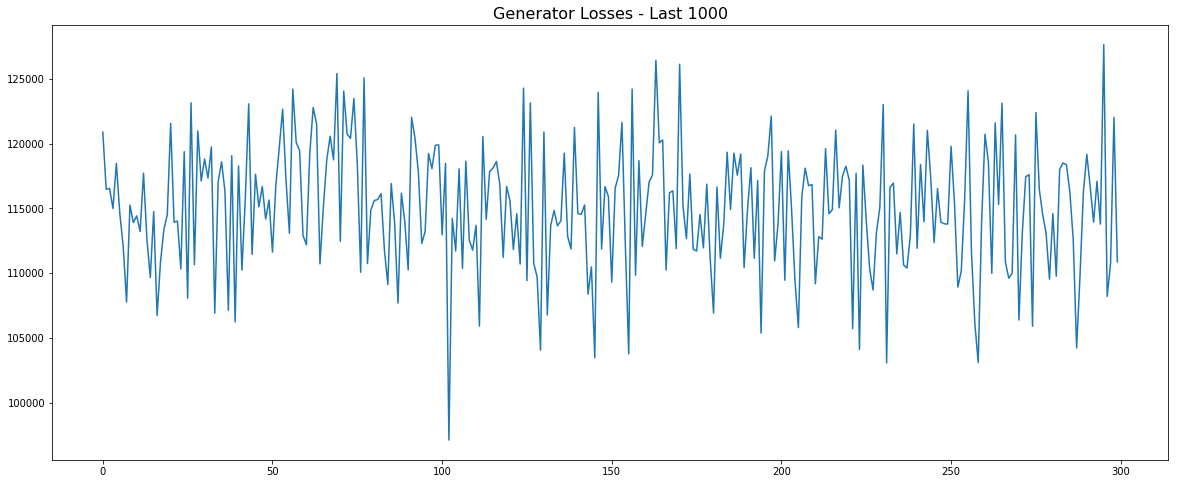

In [89]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [90]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":  before, after, mid = sample_train(num, gap)
    else:                before, after, mid = sample_test(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

In [91]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 100, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 8, gap = gap)

InvalidArgumentError: Shape [-1,8,8,256] has negative dimensions
	 [[Node: decoder_input = Placeholder[dtype=DT_FLOAT, shape=[?,8,8,256], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'decoder_input', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-a1eaa195e49d>", line 6, in <module>
    decoder_input   = tf.placeholder(tf.float32, [None, 8, 8, feature_channel], "decoder_input")
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,8,8,256] has negative dimensions
	 [[Node: decoder_input = Placeholder[dtype=DT_FLOAT, shape=[?,8,8,256], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


## - Evaluate on Test Data

In [92]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(num_show = 8, gap=1, batch_size = 8)

InvalidArgumentError: Shape [-1,8,8,256] has negative dimensions
	 [[Node: decoder_input = Placeholder[dtype=DT_FLOAT, shape=[?,8,8,256], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'decoder_input', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-a1eaa195e49d>", line 6, in <module>
    decoder_input   = tf.placeholder(tf.float32, [None, 8, 8, feature_channel], "decoder_input")
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,8,8,256] has negative dimensions
	 [[Node: decoder_input = Placeholder[dtype=DT_FLOAT, shape=[?,8,8,256], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


## How much overfitting?

In [53]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

NameError: name 'test_loss' is not defined